In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import mysql # Para ver la versión
import mysql.connector
import pymysql

## PREPARAR DATOS

In [3]:
# Asegurarse de que la columna de temperatura se llama 'temperatura'
#data['tmed'].values

In [4]:
query = f"""SELECT *
FROM valores_climatologicos"""

In [5]:
database = "AEMET"

db = mysql.connector.connect( host = "localhost",
                          user = "root",
                          password = "nueva_contraseña",
                          database = database)

cursor = db.cursor()

cursor.execute(query)
column_names = cursor.column_names
data = cursor.fetchall()

data = pd.DataFrame(data = data, columns = column_names )

cursor.close()
db.close()

### Modelo RNN

In [7]:
data

,valores_climatologicos_id,fecha,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,...,racha,horaracha,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,indicativo_id,ciudad_id,provincia_id
0,1,2022-01-01,115,19.8,0.0,13.4,0 days 06:00:00,26.1,0 days 13:10:00,7.0,...,4.4,0 days 13:40:00,41.0,95.0,0 days 22:10:00,16.0,0 days 11:20:00,1,1,1
1,2,2022-01-01,40,10.2,0.0,4.7,0 days 05:00:00,15.6,0 days 14:10:00,NaN,...,NaN,NaT,88.0,91.0,NaT,72.0,0 days 14:00:00,2,2,2
2,3,2022-01-01,410,13.6,0.0,5.7,0 days 07:00:00,21.5,0 days 14:20:00,18.0,...,9.4,0 days 11:50:00,59.0,83.0,0 days 06:50:00,29.0,0 days 14:20:00,3,3,3
3,4,2022-01-01,808,14.8,0.0,6.8,0 days 07:00:00,22.8,0 days 14:10:00,33.0,...,5.0,0 days 15:10:00,48.0,69.0,0 days 23:40:00,25.0,0 days 13:50:00,4,4,4
4,5,2022-01-01,582,6.4,0.0,-2.0,0 days 08:00:00,14.9,0 days 15:00:00,22.0,...,2.2,0 days 03:40:00,70.0,96.0,0 days 08:40:00,41.0,0 days 15:00:00,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908541,908542,2024-11-01,1062,13.2,0.6,9.4,0 days 06:30:00,17.0,0 days 12:10:00,36.0,...,5.8,0 days 13:20:00,86.0,100.0,0 days 08:00:00,62.0,0 days 12:00:00,133,132,44
908542,908543,2024-11-01,1030,NaN,113.0,NaN,NaT,NaN,NaT,33.0,...,14.7,0 days 14:10:00,NaN,NaN,NaT,NaN,NaT,202,201,6
908543,908544,2024-11-01,125,NaN,NaN,NaN,NaT,NaN,NaT,NaN,...,NaN,NaT,87.0,NaN,NaT,NaN,NaT,444,440,52
908544,908545,2024-11-01,340,17.0,0.0,13.0,NaT,21.1,0 days 14:33:00,NaN,...,NaN,NaT,83.0,96.0,0 days 23:10:00,64.0,NaT,404,400,17


In [39]:
# Normalización de los datos
temp = data["tmed"].dropna()
temperatures = temp
scaler = MinMaxScaler(feature_range=(0, 1))
temperatures = scaler.fit_transform(temperatures.values.reshape(-1, 1))

In [41]:

# Crear secuencias de datos
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)
time_step = 10
X, y = create_dataset(temperatures, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = Sequential()
model.add(SimpleRNN(25, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(SimpleRNN(25))
model.add(Dense(1))  # Capa de salida para la predicción de temperatura
# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')
# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6)
# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=64, callbacks=[early_stopping,reduce_lr])
# Hacer predicciones
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11122/11122 ━━━━━━━━━━━━━━━━━━━━ 11s 945us/step - loss: 0.0084 - learning_rate: 0.0010
Epoch 2/100
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 10s 941us/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 3/100
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 11s 971us/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 4/100
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 11s 958us/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 5/100
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 11s 953us/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 6/100
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 11s 961us/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 7/100
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 11s 966us/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 8/100
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 11s 970us/step - loss: 0.0039 - learning_rate: 2.0000e-04
Epoch 9/100
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 11s 957us/step - loss: 0.0039 - learning_rate: 2.0000e-04
Epoch 10/100
11122/11122 ━━━━━━━━━━━━━━━━━━━━ 11s 945us/step - loss: 0.0039 - learning_rate: 2.0000e-04
Epoch 11/

Mean Absolute Error: 12.87042501505385
Mean Squared Error: 180.02474345697354


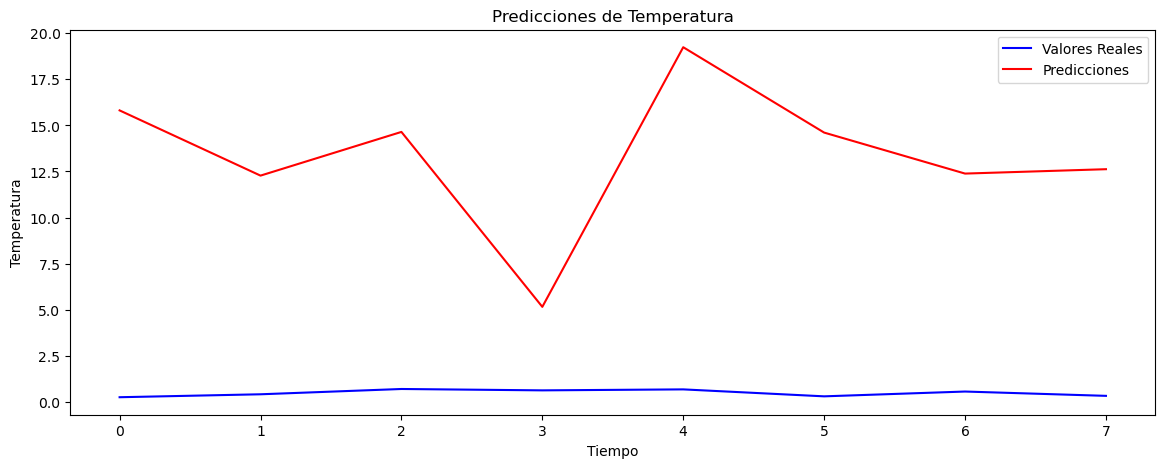

In [20]:
# Calcular métricas
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Visualización de resultados
plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Valores Reales', color='blue')
plt.plot(predictions, label='Predicciones', color='red')
plt.title('Predicciones de Temperatura')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura')
plt.legend()
plt.show()

KeyError: 'val_loss'

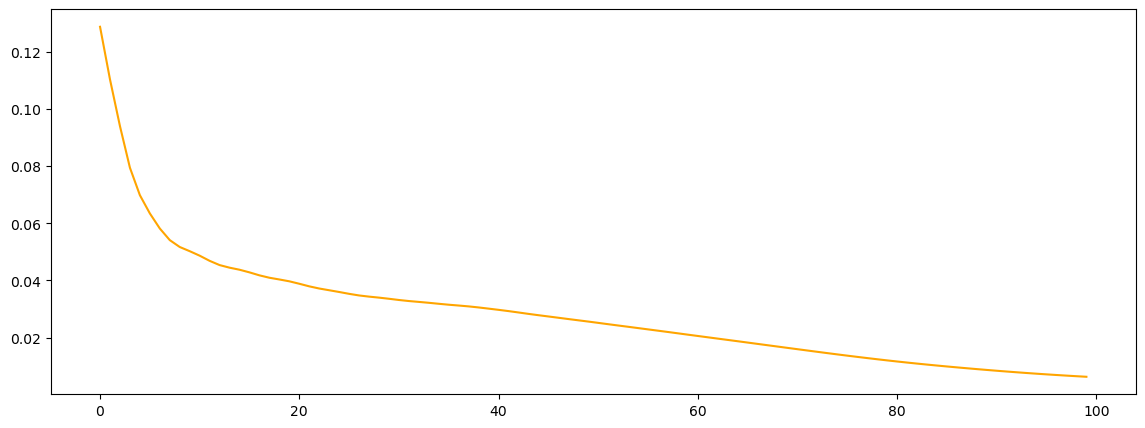

In [29]:
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento', color='orange')
plt.plot(history.history['val_loss'], label='Pérdida de Validación', color='green')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## Modelo LSTM

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.2321 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2187 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2058 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1935 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1816 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1703 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1595 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1492 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1394 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1301 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1214 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step -

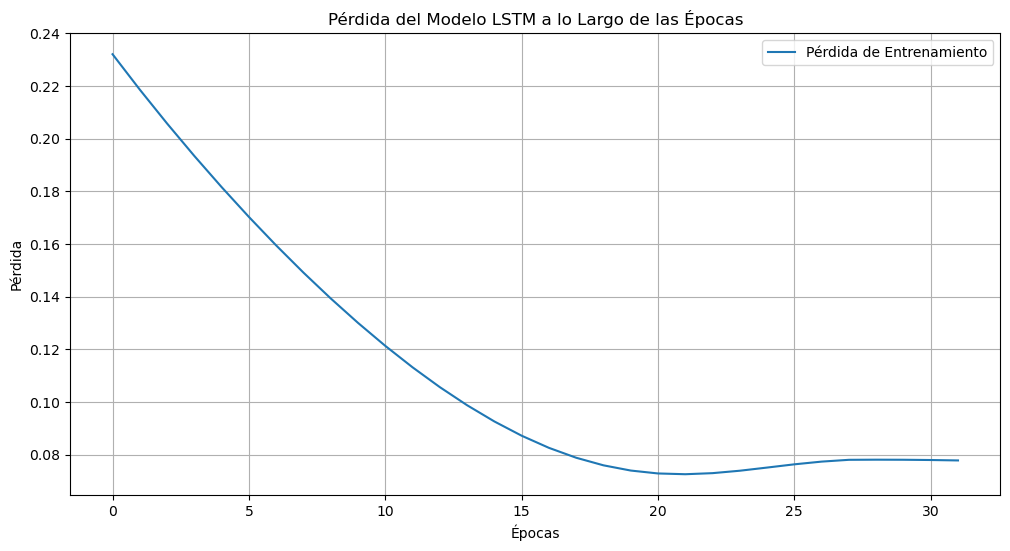

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0640 
Pérdida del modelo: 0.0651351734995842
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
RMSE: 0.2552159381447225
R²: -0.1370201489408034


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


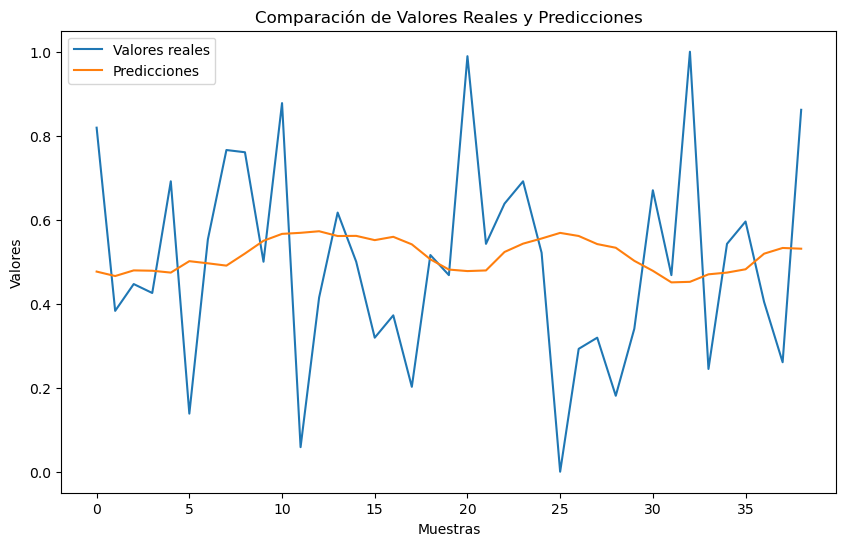

In [33]:
modelo_lstm = Sequential()
modelo_lstm.add(LSTM(25, input_shape=(X_train.shape[1], 1)))  
modelo_lstm.add(Dense(1))  
modelo_lstm.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6)

# Entrenar el modelo y guardar el historial
historial = modelo_lstm.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping, reduce_lr])

# Visualizar las métricas
plt.figure(figsize=(12, 6))
plt.plot(historial.history['loss'], label='Pérdida de Entrenamiento')
plt.title('Pérdida del Modelo LSTM a lo Largo de las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

# Evaluar el modelo
loss = modelo_lstm.evaluate(X, y)
print(f'Pérdida del modelo: {loss}')

# Obtener las predicciones
predicciones = modelo_lstm.predict(X)

# Calcular métricas adicionales
rmse = mean_squared_error(y, predicciones, squared=False)
r2 = r2_score(y, predicciones)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

plt.figure(figsize=(10, 6))
plt.plot(y, label='Valores reales')
plt.plot(predicciones, label='Predicciones')
plt.title('Comparación de Valores Reales y Predicciones')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.legend()
plt.show()